# BLG454E Learning From Data Homework 2

#### You are given two tasks below. You will implement a Decision Tree and an Autoencoder. Some functions and variables are given to you for your convenience, but you are free to change them or add new ones. The two things that shall not change are the imported libraries, which are only pandas and numpy, and the output format since your outputs will be evaluated automatically. Prepare a short report explaining your implementations and also comment your code whenever its needed. If you have any questions or need clarification on any part of the assignment, please do not hesitate to reach out via email at sentop22@itu.edu.tr.

##### Iris dataset is given for you to run tests on your algorithms. Actual test data may include the iris dataset, but make your code modular to accept more (or less) features and more (or less) data so that it works in other datasets as well. The output for Decision Tree must be written to a file named `output_decision_tree.csv` and the output for Autoencoder must be written to a file named `output_autoencoder.csv`.

In [7]:
# Fatih BASKIN
# 150210710

from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

# Load the Iris dataset
iris = load_iris()

# Create a DataFrame from the dataset
iris_df = pd.DataFrame(data=np.c_[iris['data'], iris['target']], columns=iris['feature_names'] + ['target'])

# Save the dataset to a CSV file
iris_df.to_csv('iris_dataset.csv', index=False)


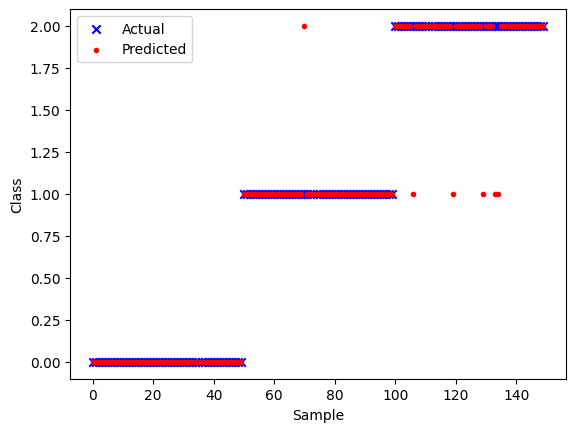

In [8]:
# Fatih BASKIN
# 150210710

import numpy as np
import pandas as pd

EPSILON = 0.0001

# Fatih Baskın
# 150210710

class Node:
    def __init__(self, X, y, used_features=None):
        # Node class for the decision tree
        # X is the feature matrix for the node
        # y is the target variable for the node
        # used_features is the list of features that have been used for splitting the node so far
        self.X = X
        self.y = y
        if used_features is None:
            self.used_features = []
        else:
            self.used_features = used_features

        # Tree parameters
        self.left = None
        self.right = None

        # Node parameters
        self.feature_index = None
        self.threshold_value = None
        self.impurity = None
        self.isPure = False
        self.isClass = False
        self.class_type = None

        # Train the node
        self.train_node(X, y)

    def train_node(self, X, y):
        # Check if the node is pure, if yes then set the isPure flag to True
        for item in y:
            if item != y[0]:
                self.isPure = False
                break
            else:
                self.isPure = True

        # Check if the node is a class, if yes then set the isClass flag to True
        # A node is a class if all the samples in the node belong to the same class
        if self.isPure:
            self.isClass = True
            self.class_type = y[0]
            return

        # If the used features are equal to the number of features, then set the isClass flag to True
        # A node is a class if all the features have been used
        if len(self.used_features) == self.X.shape[1]:
            self.isClass = True
            self.class_type = self.get_class(y)
            return

        # Find the best feature and threshold value for splitting the node
        self.find_best_feature(X, y)

    def find_best_feature(self, X, y):
        # Find the best feature and threshold value for splitting the node
        # Initialize the impurity to a very large value
        self.impurity = float("inf")

        for feature_iteration in range(X.shape[1]):
            # Check if the feature has been used
            if feature_iteration in self.used_features:
                continue

            # Get the best threshold for the feature
            threshold, impurity = self.find_best_treshold(
                X, y, feature_iteration)

            # Check if the impurity is less than the current impurity
            if impurity < self.impurity:
                self.impurity = impurity
                self.feature_index = feature_iteration
                self.threshold_value = threshold

        # After finding the best feature and threshold, add the feature to the used features
        self.used_features.append(self.feature_index)

    def get_class(self, y):
        # Get the class type for the node
        class_map = {}
        # Get the count of each class
        for item in y:
            prev = class_map.get(item, 0)
            class_map[item] = prev + 1

        # Get the class with the maximum count
        max_count = 0
        max_class = None
        for key in class_map:
            if class_map[key] > max_count:
                max_count = class_map[key]
                max_class = key

        return max_class

    def split_on_feature(self, X, y):
        # Get the left and right baskets
        left_basket = []
        right_basket = []
        left_labels = []
        right_labels = []

        for index, sample in enumerate(X[:, self.feature_index]):
            if sample < self.threshold_value:
                left_basket.append(X[index])
                left_labels.append(y[index])
            else:
                right_basket.append(X[index])
                right_labels.append(y[index])

        # Convert the baskets to numpy arrays
        left_basket = np.array(left_basket)
        right_basket = np.array(right_basket)

        # Get the left and right labels
        left_labels = np.array(left_labels)
        right_labels = np.array(right_labels)

        return left_basket, right_basket, left_labels, right_labels

    def find_best_treshold(self, X, y, feature):
        # Get the min and max values for the feature
        min_value = np.min(X[:, feature])
        max_value = np.max(X[:, feature])

        # Use binary search for finding the best threshold
        left_boundary = min_value
        right_boundary = max_value

        while (left_boundary < right_boundary):
            # Get the mid point
            mid_point = left_boundary + (right_boundary - left_boundary) / 2

            # Get the mid point of the left and right boundaries
            left_midpoint = left_boundary + (mid_point - left_boundary) / 2
            right_midpoint = mid_point + (right_boundary - mid_point) / 2

            # Get the gini impurity for the mid point and the mid point of the left and right boundaries
            mid_point_gini = self.get_gini_impurity(X, y, mid_point, feature)
            left_gini = self.get_gini_impurity(X, y, left_midpoint, feature)
            right_gini = self.get_gini_impurity(X, y, right_midpoint, feature)

            # Check epsilon
            if right_boundary - left_boundary < EPSILON:
                break

            # Check if the mid point is the best threshold
            if mid_point_gini < left_gini and mid_point_gini < right_gini:
                break

            # Check if the mid point of the left and right boundaries is the best threshold
            elif left_gini < mid_point_gini:
                right_boundary = mid_point

            else:
                left_boundary = mid_point

        return mid_point, mid_point_gini

    def get_gini_impurity(self, X, y, threshold, feature):
        # There are left and right baskets
        # The left basket has the values that are less than the threshold
        # The right basket has the values that are greater than or equal to the threshold
        left_basket = {}
        left_basket_size = 0
        right_basket = {}
        right_basket_size = 0

        # Get the left and right baskets
        for index, sample in enumerate(X[:, feature]):
            if sample < threshold:
                prev = left_basket.get(y[index], 0)
                left_basket[y[index]] = prev + 1
                left_basket_size += 1
            else:
                prev = right_basket.get(y[index], 0)
                right_basket[y[index]] = prev + 1
                right_basket_size += 1

        # Calculate the gini impurity for the left and right baskets
        left_gini = 0.0
        if left_basket_size != 0:
            for key in left_basket:
                probability = left_basket[key] / left_basket_size
                left_gini += probability * (1-probability)
        right_gini = 0.0
        if right_basket_size != 0:
            for key in right_basket:
                probability = right_basket[key] / right_basket_size
                right_gini += probability * (1-probability)

        # Calculate the weighted gini impurity
        total_size = left_basket_size + right_basket_size
        left_weight = left_basket_size / total_size
        right_weight = right_basket_size / total_size
        weighted_gini = left_weight * left_gini + right_weight * right_gini

        return weighted_gini


class DecisionTree:
    def __init__(self):
        self.root = None

    def train(self, X, y):
        # All nodes can train itself when initialized, we need to train all nodes recursively
        self.root = Node(X.to_numpy(), y.to_numpy(), [])
        self.train_recursive(self.root)

    def train_recursive(self, node):
        # If the node is a class, then return
        if node.isClass:
            return

        # Split the node on the best feature and threshold
        left_basket, right_basket, left_labels, right_labels = node.split_on_feature(
            node.X, node.y)
        node.left = Node(left_basket, left_labels, node.used_features)
        node.right = Node(right_basket, right_labels, node.used_features)

        # Train the left and right nodes recursively
        self.train_recursive(node.left)
        self.train_recursive(node.right)

    def predict(self, X):
        # Predict the target variable for the given features
        predictions = []
        for sample in X.to_numpy():
            prediction = self.predict_recursive(self.root, sample)
            predictions.append(prediction)

        return predictions

    def predict_recursive(self, node, sample):
        # If the node is a class, then return the class type
        if node.isClass:
            return node.class_type

        # Check if the sample belongs to the left or right basket
        if sample[node.feature_index] < node.threshold_value:
            return self.predict_recursive(node.left, sample)
        else:
            return self.predict_recursive(node.right, sample)


# Load your dataset using pandas
# Assume 'data' is your DataFrame with features and target variable
# Modify this according to your dataset
data = pd.read_csv('iris_dataset.csv')

# Split the data into features (X) and target variable (y)
X = data.drop('target', axis=1)
y = data['target']


# Instantiate and train the decision tree
dt = DecisionTree()
dt.train(X, y)

# Make predictions
predictions = dt.predict(X)

# Save predictions to a CSV file
output_df = pd.DataFrame({'Actual': y, 'Predicted': predictions})
output_df.to_csv('decision_tree_predictions.csv', index=False)

import matplotlib.pyplot as plt

plt.scatter(range(len(data['target'].values)), data['target'].values, marker='x', c='b', label='Actual')
plt.scatter(range(len(predictions)), predictions, marker = '.', c='r', label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Class')
plt.legend()
plt.show()


# Autoencoder

Encoder part is sigmoid, decoder part is a linear function. Encoder part dakes $d$ features, and yields $k$ outputs. Decoder part then takes $k$ features, and yields $d$ outputs.

## Problems

I think due to our autencoder having just one layer, it either diverges (gradient descent) or gets stuck such that every value of the same column in the autoencoder_output.csv

Also, I couldn't linearize the derivative calculations for encoder using numpy. I have resorted to use nested loops. This makes the runtime too long.

High learning rates, high epoches, low hidden size creates the affermentioned problem.

## Best Values
These are the best values I have found so far:
* Epoch : 100
* Learning Rate : 0,0001
* Hidden Size : 128

## Possible solutions
Using tangent hyperbolic function, since it is easier to take the derivative of.

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch will be given in increments of:  10
Epoch:  20
Epoch:  30
Epoch:  40
Epoch:  50
Epoch:  60
Epoch:  70
Epoch:  80
Epoch:  90


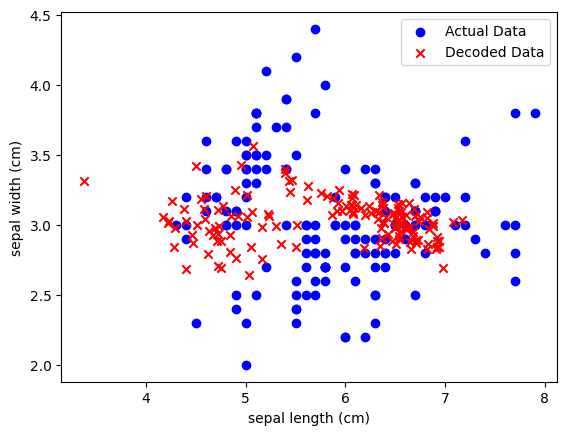

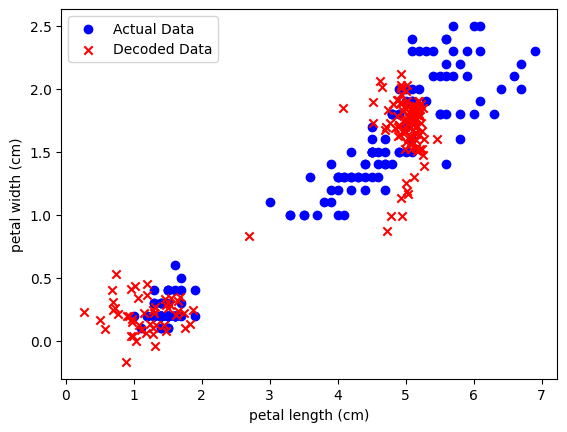

In [9]:
# Fatih BASKIN
# 150210710

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


class Autoencoder:
    def __init__(self, input_size, hidden_size):
        # Define your autoencoder architecture
        self.weights = {
            'encoder': np.random.randn(input_size, hidden_size),
            'decoder': np.random.randn(hidden_size, input_size)
        }
        self.biases = {
            'encoder': np.zeros((1, hidden_size)),
            'decoder': np.zeros((1, input_size))
        }
        self.hidden_size = hidden_size
        self.input_size = input_size

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        return np.matmul(z.T, (1 - z))

    def encode_calculation(self, X):
        z = np.matmul(X, self.weights['encoder']) + self.biases['encoder']
        return self.sigmoid(z)

    def decode_calculation(self, encoded_X):
        return np.matmul(encoded_X, self.weights['decoder']) + self.biases['decoder']

    def encode(self, X: pd.DataFrame):
        return self.encode_calculation(X.values)

    def decode(self, encoded_X):
        return self.decode_calculation(encoded_X)

    def train_iteration(self, X, learning_rate=0.01):
        encoded_X = self.encode_calculation(X)
        decoded_X = self.decode_calculation(encoded_X)

        # Derivative of loss of output layer = -2E(X - y), simplified as -E(X - y)
        # Derivative of decoder layer = -E(X - y) * O
        derivative_decoder_biases = - \
            np.sum((X - decoded_X), axis=0).reshape(1, self.input_size)

        derivative_decoder_weights = np.matmul(encoded_X.T, (X - decoded_X))

        # Derivative of loss of hidden layer = -E((X - y) * w) * O * (1 - O),
        # O being the output of the encoder layer and w being the weights of the decoder layer
        # Derivative of encoder layer = -E((X - y) * w) * O * (1 - O) * X,
        # X being the input
        derivative_encoder_biases = np.zeros((1, self.hidden_size))
        derivative_encoder_weights = np.zeros((
            self.input_size, self.hidden_size))

        # derivative_encoder_weights = -np.matmul(X.T, np.matmul((X - decoded_X), np.matmul(
        #     self.weights['decoder'].T, self.sigmoid_derivative(encoded_X))))

        # derivative_encoder_biases = -np.sum(np.matmul((X - decoded_X), np.matmul(
        #     self.weights['decoder'].T, self.sigmoid_derivative(encoded_X))), axis=0)

        # Couldn't linearize the equation, used the nested loop instead
        num_examples = X.shape[0]
        for n in range(num_examples):
            for i in range(self.hidden_size):
                for j in range(self.input_size):
                    derivative_encoder_weights[j][i] -= (
                        X[n][j] - decoded_X[n][j]) * encoded_X[n][i] * (1 - encoded_X[n][i]) * X[n][j]

                    derivative_encoder_biases[0][i] -= (
                        X[n][j] - decoded_X[n][j]) * encoded_X[n][i] * (1 - encoded_X[n][i])

        # Derivatives are negative, so we add them to the weights and biases
        self.weights['decoder'] += learning_rate * derivative_decoder_weights
        self.biases['decoder'] += learning_rate * derivative_decoder_biases
        self.biases['encoder'] += learning_rate * derivative_encoder_biases
        self.weights['encoder'] += learning_rate * derivative_encoder_weights

    def epoch_counter(self, epoch, epoch_limit, epoch_modulo, epoch_increment):
        if epoch % epoch_modulo == 0:
            print("Epoch: ", epoch)
        if epoch == epoch_limit:
            epoch_limit *= epoch_increment
            epoch_modulo *= epoch_increment
            print("Epoch will be given in increments of: ", epoch_modulo)
        return epoch_limit, epoch_modulo

    def train(self, X, learning_rate=0.0001, epochs=100):
        values = X.values
        epoch_limit = 10
        epoch_modulo = 1
        epoch_increment = 10
        for epoch in range(epochs):
            epoch_limit, epoch_modulo = self.epoch_counter(epoch, epoch_limit,
                                                           epoch_modulo, epoch_increment)
            self.train_iteration(values, learning_rate)


# Load your dataset using pandas
# Assume 'data' is your DataFrame with features
# Modify this according to your dataset
data = pd.read_csv('iris_dataset.csv')

# Split the data into features (X)
X = data.drop('target', axis=1)

# Instantiate and train the autoencoder
input_size = X.shape[1]
hidden_size = 128  # Adjust the hidden size based on your requirements
ae = Autoencoder(input_size, hidden_size)
ae.train(X)

# Encode and decode the data
encoded_data = ae.encode(X)
decoded_data = ae.decode(encoded_data)

# Save decoded data to a CSV file
output_df = pd.DataFrame(decoded_data, columns=X.columns)
output_df.to_csv('autoencoder_output.csv', index=False)

# Print the actual and decoded data

plt.scatter(X.values[:, 0], X.values[:, 1],
            label='Actual Data', color='blue', marker='o')
plt.scatter(decoded_data[:, 0], decoded_data[:, 1],
            label='Decoded Data', color='red', marker='x')

# Add labels and title
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])

# Add a legend
plt.legend()
plt.show()

plt.scatter(X.values[:, 2], X.values[:, 3],
            label='Actual Data', color='blue', marker='o')
plt.scatter(decoded_data[:, 2], decoded_data[:, 3],
            label='Decoded Data', color='red', marker='x')

# Add labels and title
plt.xlabel(X.columns[2])
plt.ylabel(X.columns[3])

# Add a legend
plt.legend()
plt.show()
